Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.



Instructions for updating:
non-resource variables are not supported in the long term
Compiling model...
Building feed-forward neural network...
'build' took 1.830490 s


'compile' took 18.044549 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [9.10e-01, 0.00e+00, 0.00e+00, 1.58e+00, 1.24e+00]    [8.73e-01, 0.00e+00, 0.00e+00, 1.58e+00, 1.24e+00]    []  
100       [1.13e-03, 8.59e-07, 5.94e-08, 3.11e-06, 6.21e-06]    [2.41e-03, 8.59e-07, 5.94e-08, 3.11e-06, 6.21e-06]    []  
200       [2.69e-04, 8.45e-08, 1.11e-06, 2.65e-07, 1.11e-10]    [5.77e-04, 8.45e-08, 1.11e-06, 2.65e-07, 1.11e-10]    []  
300       [1.05e-04, 2.45e-08, 1.41e-07, 1.24e-07, 2.57e-12]    [2.25e-04, 2.45e-08, 1.41e-07, 1.24e-07, 2.57e-12]    []  
400       [5.97e-05, 1.14e-08, 3.06e-08, 1.78e-07, 6.70e-14]    [1.28e-04, 1.14e-08, 3.06e-08, 1.78e-07, 6.70e-14]    []  
500       [3.75e-05, 5.68e-09, 1.08e-

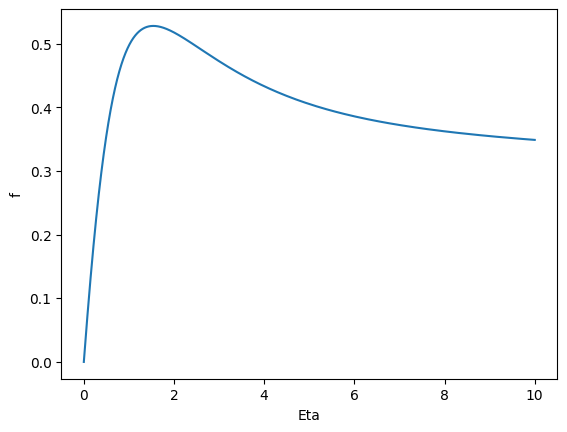

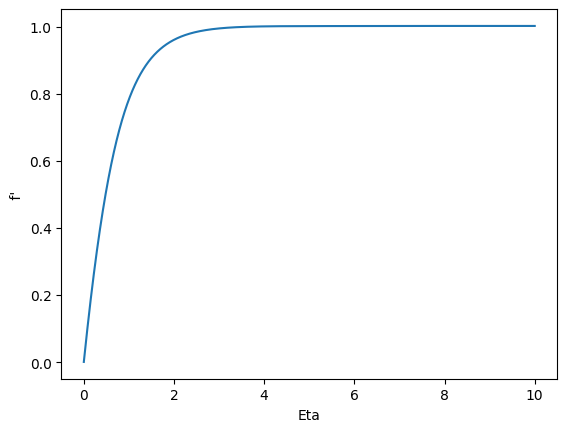

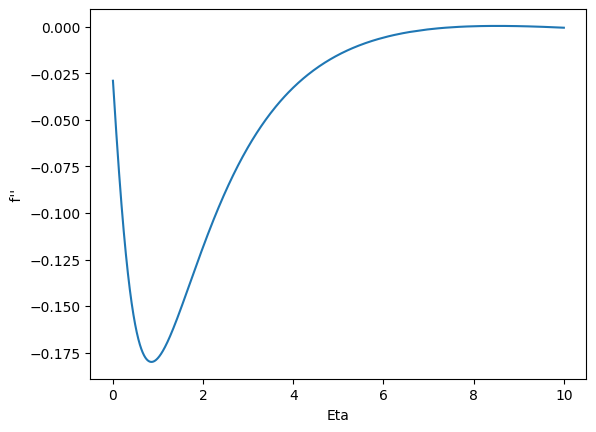

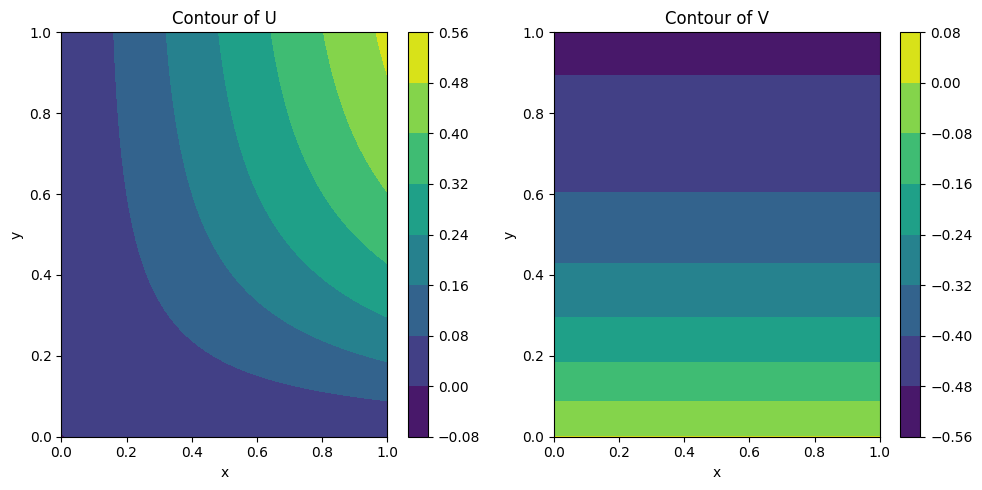

In [1]:
import deepxde as dde
import matplotlib.pyplot as plt
from deepxde.backend import tf
import numpy as np
import pandas as pd

eta_min = 0
eta_max = 10
Domain_Boundary_layer = dde.geometry.Interval(eta_min,eta_max)

m = 1
def Falkner_skan(x,y):
    # Lets say the angle of inclination is theta
    theta = np.pi
    beta = theta/np.pi
    m = (beta)/(2-beta)
    #Here the x represents the input with is a N*1 matrics of eta as input
    # Y is the output that is the f , f' , f'' which is N*3 matric
    f,f_prime,f_double_prime = y[:,0:1],y[:,1:2],y[:,2:3]

    f_double_prime = tf.gradients(f_prime,x)[0]    # For correction
    f_triple_prime = tf.gradients(f_double_prime,x)[0]
    return f_triple_prime + (f*f_double_prime) + ((2*m)/(m+1))*(1-(f_prime**2))

'''Boundary condition for the streamfunction to be zero along surface (eta)'''
def f_boundary_value(x):
    return np.zeros((x.shape[0],1))
def f_boundary(x,on_boundary):
    return np.isclose(x[0],0)

'''Boundary condition for no slip'''
def f_prime_boundary_value(x):
    return np.zeros((x.shape[0],1))
def f_prime_boundary(x,on_boundary):
    return np.isclose(x[0],0)

'''Boundary condition for no_stress at infinity'''
def f_infinity_prime_boundary_value(x):
    return np.ones((x.shape[0],1))
def f_infinity_prime_boundary(x,on_boundary):
    return np.isclose(x[0],10)

'''Stress at infinity is zero'''
def f_double_prime_boundary_value(x):
    return np.zeros((x.shape[0],1))
def f_double_prime_boundary(x,on_boundary):
    return np.isclose(x[0],10)

'''Boundary condition with deepxde'''
f_condition = dde.icbc.DirichletBC(Domain_Boundary_layer,f_boundary_value,f_boundary,component=0)
f_prime__condition = dde.icbc.DirichletBC(Domain_Boundary_layer,f_prime_boundary_value,f_prime_boundary,component=1)
f_infinity_prime__condition = dde.icbc.DirichletBC(Domain_Boundary_layer,f_infinity_prime_boundary_value,f_infinity_prime_boundary,component=1)
f_double_prime_boundary = dde.icbc.DirichletBC(Domain_Boundary_layer,f_double_prime_boundary_value,f_double_prime_boundary,component=2)

data_boundary_layer = dde.data.PDE(
    Domain_Boundary_layer,
    Falkner_skan,
    [f_condition,f_prime__condition,f_infinity_prime__condition,f_double_prime_boundary],
    num_domain=5000, num_boundary=6000,
        num_test=5000
    )

'''Defining neural network'''
layer_size_Boundary = [1] + [50] * 6 + [3]
net_Boundary = dde.nn.FNN(layer_size_Boundary, "tanh", "Glorot uniform")

'''Compiling the model'''
model_Boundary = dde.Model(data_boundary_layer, net_Boundary)
model_Boundary.compile("adam", lr=0.001)


model_Boundary.train(epochs = 5000,display_every = 100,disregard_previous_best=True)

def result_boundary():
    X = np.linspace(-0,10,10000)
    points = np.column_stack([X.ravel()])

    prediction = model_Boundary.predict(points)
    f = prediction[:,0]
    f_prime = prediction[:,1]
    f_double_prime = prediction[:,2]

    f_grid = f.reshape(X.shape)
    f_prime_grid = f_prime.reshape(X.shape)
    f_double_prime_grid = f_double_prime.reshape(X.shape)

    plt.figure(1)
    plt.plot(X,f_grid)
    plt.xlabel("Eta")
    plt.ylabel("f")
    print("shape of f is ",f.shape)
    
    plt.figure(2)
    plt.plot(X,f_prime_grid)
    plt.xlabel("Eta")
    plt.ylabel(" f' ")
    print("shape of f' is ",f_prime.shape)
    
    plt.figure(3)
    plt.plot(X,f_double_prime_grid)
    plt.xlabel("Eta")
    plt.ylabel(" f'' ")
    print("shape of f'' is ",f_double_prime.shape)

result_boundary()

# Define the boundary grid
x_boundary = np.linspace(0, 1, 100)
y_boundary = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x_boundary, y_boundary)
eta = Y * ((m + 1) / 2)**0.5 * X**((m - 1) / 2)
# Flatten the points for model prediction
points = np.column_stack([eta.ravel()])

# Make predictions
prediction = model_Boundary.predict(points)  # Ensure model outputs (10000, 3)
f = prediction[:, 0]
df = prediction[:, 1]
ddf = prediction[:, 2]

# Reshape predictions into grids
f_grid = f.reshape(X.shape)
df_grid = df.reshape(X.shape)
ddf_grid = ddf.reshape(X.shape)

# Compute eta, U, and V with correct grid usage
eta = Y * ((m + 1) / 2)**0.5 * X**((m - 1) / 2)
U = X**m * f_grid
V = -(((m + 1) / 2) * X**(m - 1))**0.5 * (f_grid + ((m - 1) / (m + 1)) * eta * df_grid)

# Plot the contours
plt.figure(figsize=(10, 5))

# Contour plot for U
plt.subplot(1, 2, 1)
contour_U = plt.contourf(X,Y,U)
plt.title('Contour of U')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar(contour_U)

# Contour plot for V
plt.subplot(1, 2, 2)
contour_V = plt.contourf(X,Y,V)
plt.title('Contour of V')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar(contour_V)

plt.tight_layout()
plt.show()